In [ ]:
"""
Use all variables (continuous, categorical) as features
Use X_adasyn and y_adasyn as train data (imbalanced classes handled)

Refine models (continued):

4. Decision tree - classification
    - Grid search CV: max_depth, min_samples_leaf, max_features
    - P/R: 0.46/0.75
    
5. Random Forests
    - Grid search CV: n_estimators, max_depth, min_samples_leaf, max_features
    - P/R: 0.47/0.78
    
6. XGBoost
    - Grid search CV: n_estimators, max_depth, learning_rate, subsample, min_child_weight, colsample_bytree (?)
    - P/R: 0.29/0.98

Conclusion:
ROC AUC highest - Decision Tree
Recall highest - XGBoost (but with low precision)

"""

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, log_loss

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, 
                              AdaBoostClassifier, BaggingRegressor, StackingClassifier)

In [31]:
# Load data
df_train = pd.read_pickle('../dump/df_train.csv')
df_test = pd.read_pickle('../dump/df_test.csv')


X_train = pd.read_pickle('../dump/X_adasyn')
y_train = pd.read_pickle('../dump/y_adasyn')
X_test = pd.read_pickle('../dump/X_test_processed')
y_test = df_test['target']

In [32]:
X_train.shape

(28836, 32)

In [33]:
def quick_test(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

def quick_test_afew_times(model, X_train, y_train, X_test, y_test, n=10):
    return np.mean([quick_test(model, X_train, y_train, X_test, y_test) for j in range(n)])

In [43]:
# # Linear SVC
# linearsvc = LinearSVC()

# # Do the test 10 times with a LinearSVC and get the average score
# quick_test_afew_times(linearsvc, X_train, y_train, X_test, y_test)

### 4. Decision tree - classification

In [34]:
# Decision tree
decisiontree = DecisionTreeClassifier(max_depth=4)
quick_test_afew_times(decisiontree, X_train, y_train, X_test, y_test)

0.6115547205260687

In [35]:
pred = decisiontree.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred))
print('ROC AUC score:',roc_auc_score(y_test,decisiontree.predict_proba(X_test)[:, 1]),'\n')
print('Classification report (Naive Bayes):\n\n',classification_report(y_test,pred))

Accuracy score: 0.6115547205260686
ROC AUC score: 0.7723045002504114 

Classification report (Naive Bayes):

               precision    recall  f1-score   support

           0       0.88      0.54      0.67      1553
           1       0.39      0.81      0.53       576

    accuracy                           0.61      2129
   macro avg       0.64      0.67      0.60      2129
weighted avg       0.75      0.61      0.63      2129



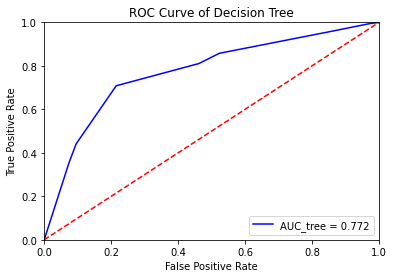

In [36]:
# Decision Tree ROC curve
y_scores = decisiontree.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_tree = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Decision Tree')
plt.show()

#### Grid search cross-validation

In [37]:
decisiontree_2 = DecisionTreeClassifier()
decisiontree_2.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [38]:
max_depth = [3,4,5,6]
min_samples_leaf = [0.04,0.06,0.08]
max_features = [0.2,0.4,0.6,0.8]

In [39]:
# Define grid search
grid = dict(max_depth = max_depth, min_samples_leaf = min_samples_leaf, max_features = max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=decisiontree_2, param_grid=grid, n_jobs=-1, cv=5, scoring='recall',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: 0.742857 using {'max_depth': 6, 'max_features': 0.2, 'min_samples_leaf': 0.08}


In [41]:
decisiontree_3 = grid_search.best_estimator_
decisiontree_3.fit(X_train,y_train)
pred = decisiontree_3.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred))
print('ROC AUC score:',roc_auc_score(y_test,decisiontree_3.predict_proba(X_test)[:, 1]),'\n')
print('Classification report (Decision Tree):\n\n',classification_report(y_test,pred))

Accuracy score: 0.7191169563175199
ROC AUC score: 0.7754704156829078 

Classification report (Decision Tree):

               precision    recall  f1-score   support

           0       0.89      0.70      0.79      1553
           1       0.49      0.76      0.59       576

    accuracy                           0.72      2129
   macro avg       0.69      0.73      0.69      2129
weighted avg       0.78      0.72      0.73      2129



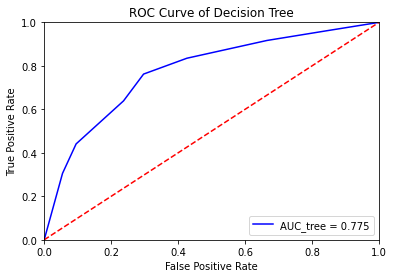

In [42]:
# Decision Tree ROC curve
y_scores = decisiontree_3.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_tree = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Decision Tree')
plt.show()

### 5. Random Forests

In [43]:
# Random Forests
randomforest = RandomForestClassifier(n_estimators=100)
quick_test_afew_times(randomforest, X_train, y_train, X_test, y_test)

0.7095819633630812

In [44]:
pred = randomforest.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred))
print('ROC AUC score:',roc_auc_score(y_test,randomforest.predict_proba(X_test)[:, 1]),'\n')
print('Classification report (Random Forests):\n\n',classification_report(y_test,pred))

Accuracy score: 0.7111319868482856
ROC AUC score: 0.7502308480002862 

Classification report (Random Forests):

               precision    recall  f1-score   support

           0       0.86      0.72      0.78      1553
           1       0.48      0.70      0.57       576

    accuracy                           0.71      2129
   macro avg       0.67      0.71      0.67      2129
weighted avg       0.76      0.71      0.72      2129



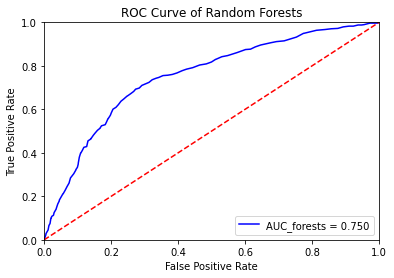

In [45]:
# Random Forests ROC curve
y_scores = randomforest.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_forests = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Random Forests')
plt.show()

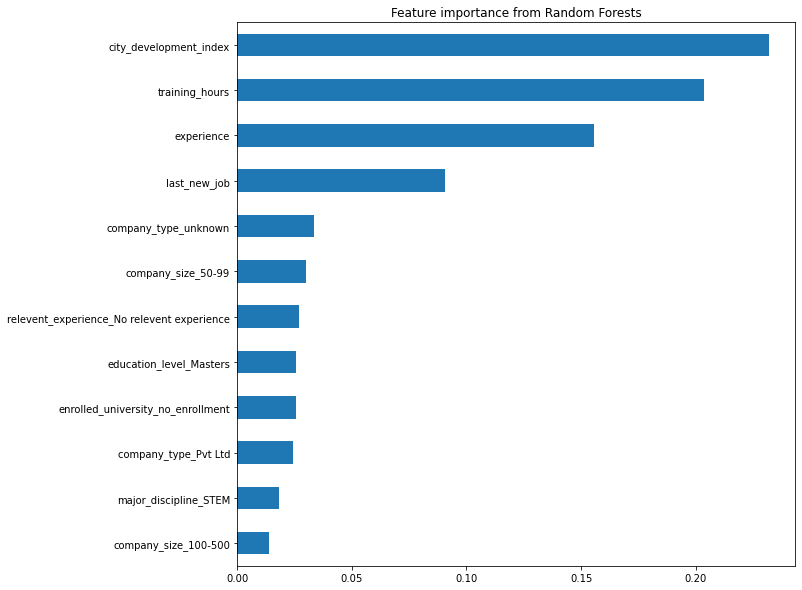

In [46]:
# Feature importance
pd.Series(randomforest.feature_importances_, index = X_train.columns).nlargest(12).\
plot(kind = 'barh',figsize = (10, 10),title = 'Feature importance from Random Forests').\
invert_yaxis();

#### Grid search cross-validation

In [76]:
randomforest_2 = RandomForestClassifier()
randomforest_2.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [79]:
n_estimators = [300,400,500,600]
max_depth = [4,6,8]
min_samples_leaf = [0.1,0.2,0.3]
max_features = ['log2','sqrt']

In [80]:
# Define grid search
grid = dict(n_estimators = n_estimators, max_depth = max_depth,\
            min_samples_leaf = min_samples_leaf, max_features = max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=randomforest_2, param_grid=grid, n_jobs=-1, cv=5, scoring='recall',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

Best: 0.726531 using {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'n_estimators': 300}


In [81]:
randomforest_3 = grid_search.best_estimator_
randomforest_3.fit(X_train,y_train)
pred = randomforest_3.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (Decision Tree):\n\n',classification_report(y_test,pred))

Accuracy score: 0.7045561296383278 

Classification report (Decision Tree):

               precision    recall  f1-score   support

           0       0.89      0.68      0.77      1553
           1       0.47      0.78      0.59       576

    accuracy                           0.70      2129
   macro avg       0.68      0.73      0.68      2129
weighted avg       0.78      0.70      0.72      2129



In [ ]:
# Random Forests ROC curve
y_scores = randomforest_3.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_forests = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Random Forests')
plt.show()

### 6. XGBoost

In [50]:
X_train.rename(columns={'company_size_<10':'company_size_lessthan10'},inplace=True)
X_test.rename(columns={'company_size_<10':'company_size_lessthan10'},inplace=True)

In [51]:
# Split train data into 2: 80% train, 20% validation

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2)

In [54]:
xgb.get_params()

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.5,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.05,
 'max_delta_step': 0,
 'max_depth': 4,
 'min_child_weight': 2,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 30000,
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.2,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'use_label_encoder': False}

In [65]:
xgb = XGBClassifier( 
        n_estimators=30000,
        max_depth=4,
        objective='binary:logistic', #new objective
        use_label_encoder=False,
        learning_rate=.05, 
        subsample=.2,
        min_child_weight=2,
        colsample_bytree=.5)

eval_set=[(X_train,y_train),(X_val,y_val)]

fit_model = xgb.fit(
                X_train, y_train, 
                eval_set=eval_set,
                eval_metric='error', #(wrong cases)/(all cases)
                early_stopping_rounds=50,
                verbose=False)

accuracy_score(y_test, xgb.predict(X_test, ntree_limit=xgb.best_ntree_limit)) 
pred = xgb.predict(X_test, ntree_limit=xgb.best_ntree_limit)
print('Accuracy score:',accuracy_score(y_test,pred))
print('ROC AUC score:',roc_auc_score(y_test,xgb.predict_proba(X_test)[:, 1]),'\n')
print('Classification report (XGBoost):\n\n',classification_report(y_test,pred))

[11:00:29] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy score: 0.3555659934241428
ROC AUC score: 0.7246408161622665 

Classification report (XGBoost):

               precision    recall  f1-score   support

           0       0.92      0.13      0.22      1553
           1       0.29      0.97      0.45       576

    accuracy                           0.36      2129
   macro avg       0.60      0.55      0.34      2129
weighted avg       0.75      0.36      0.29      2129



In [70]:
# Tune Learning Rate
xgb = XGBClassifier( 
        n_estimators=30000,
        max_depth=4,
        objective='binary:logistic', #new objective
        use_label_encoder=False,
        learning_rate=.5, 
        subsample=.2,
        min_child_weight=2,
        colsample_bytree=.5)

eval_set=[(X_train,y_train),(X_val,y_val)]

fit_model = xgb.fit(
                X_train, y_train, 
                eval_set=eval_set,
                eval_metric='error', #(wrong cases)/(all cases)
                early_stopping_rounds=50,
                verbose=False)

accuracy_score(y_test, xgb.predict(X_test, ntree_limit=xgb.best_ntree_limit)) 
pred = xgb.predict(X_test, ntree_limit=xgb.best_ntree_limit)
print('Accuracy score:',accuracy_score(y_test,pred))
print('ROC AUC score:',roc_auc_score(y_test,xgb.predict_proba(X_test)[:, 1]),'\n')
print('Classification report (XGBoost):\n\n',classification_report(y_test,pred))

[11:02:04] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy score: 0.316580554250822
ROC AUC score: 0.6757250751234171 

Classification report (XGBoost):

               precision    recall  f1-score   support

           0       0.90      0.07      0.13      1553
           1       0.28      0.98      0.44       576

    accuracy                           0.32      2129
   macro avg       0.59      0.52      0.28      2129
weighted avg       0.73      0.32      0.21      2129



In [55]:
# Tune Early Stopping Round
xgb = XGBClassifier( 
        n_estimators=30000,
        max_depth=4,
        objective='binary:logistic', #new objective
        use_label_encoder=False,
        learning_rate=.04, 
        subsample=.2,
        min_child_weight=2,
        colsample_bytree=.5)

eval_set=[(X_train,y_train),(X_val,y_val)]

fit_model = xgb.fit(
                X_train, y_train, 
                eval_set=eval_set,
                eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                early_stopping_rounds=100,
                verbose=False)

accuracy_score(y_test, xgb.predict(X_test, ntree_limit=xgb.best_ntree_limit)) 
pred = xgb.predict(X_test, ntree_limit=xgb.best_ntree_limit)
print('Accuracy score:',accuracy_score(y_test,pred))
print('ROC AUC score:',roc_auc_score(y_test,xgb.predict_proba(X_test)[:, 1]),'\n')
print('Classification report (XGBoost):\n\n',classification_report(y_test,pred))

[10:54:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy score: 0.3442930953499295
ROC AUC score: 0.7153789484510268 

Classification report (XGBoost):

               precision    recall  f1-score   support

           0       0.92      0.11      0.20      1553
           1       0.29      0.98      0.45       576

    accuracy                           0.34      2129
   macro avg       0.61      0.54      0.32      2129
weighted avg       0.75      0.34      0.26      2129



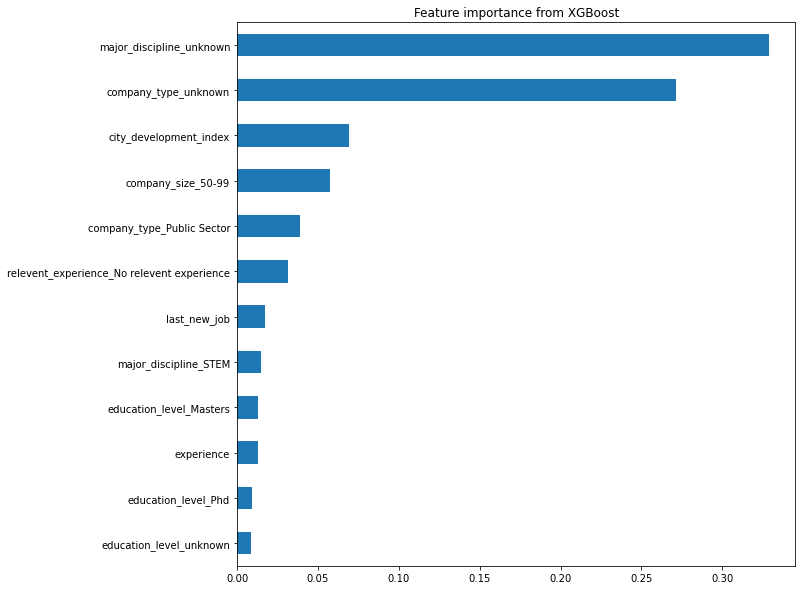

In [56]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(max_depth=12, learning_rate=1e-4,n_estimators=500)
xgb_clf.fit(X_train, y_train)
xgb_y_pred = xgb_clf.predict(X_val)

pd.Series(xgb_clf.feature_importances_, index = X_train.columns).nlargest(12).plot(kind = 'barh',
                                                                               figsize = (10, 10),
                                                                              title = 'Feature importance from XGBoost').invert_yaxis();

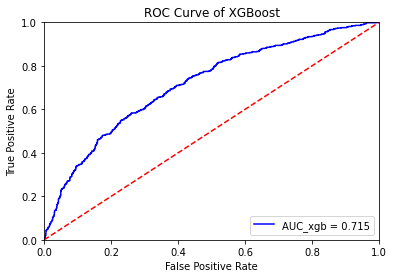

In [60]:
# XGBoost ROC curve
y_scores = xgb.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_xgb = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of XGBoost')
plt.show()

#### Grid search cross-validation

In [88]:
xgb_2 = XGBClassifier()
xgb_2.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': True,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'gamma': None,
 'gpu_id': None,
 'importance_type': 'gain',
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [89]:
n_estimators= [1000, 10000, 30000, 50000]
max_depth= [3,4,5,6]
learning_rate= [.025, .05, .1]
subsample= [.1, .2, .3]
min_child_weight= [1, 2, 3]
colsample_bytree= [.25, .5, 1]

In [ ]:
# Define grid search
grid = dict(n_estimators = n_estimators, max_depth = max_depth, learning_rate = learning_rate,\
            subsample = subsample, min_child_weight = min_child_weight, colsample_bytree = colsample_bytree)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=xgb_2, param_grid=grid, n_jobs=-1, cv=5, scoring='recall',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

In [ ]:
xgb_3 = grid_search.best_estimator_
xgb_3.fit(X_train,y_train)
pred = xgb_3.predict(X_test)
print('Accuracy score:',accuracy_score(y_test,pred),'\n')
print('Classification report (Decision Tree):\n\n',classification_report(y_test,pred))

In [ ]:
# XGBoost ROC curve
y_scores = xgb_3.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, 'b', label = 'AUC_xgb = %0.3f' % roc_auc)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of XGBoost')
plt.show()

In [167]:
# Use data before Adasyn treatment
X_train = pd.read_pickle('../dump/X_train_processed')
y_train = df_train['target']
X_test = pd.read_pickle('../dump/X_test_processed')
y_test = df_test['target']

X_train.rename(columns={'company_size_<10':'company_size_lessthan10'},inplace=True)
X_test.rename(columns={'company_size_<10':'company_size_lessthan10'},inplace=True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=2)

In [62]:
xgb = XGBClassifier( 
        n_estimators=30000,
        max_depth=4,
        objective='binary:logistic', #new objective
        use_label_encoder=False,
        learning_rate=.04, 
        subsample=.2,
        min_child_weight=2,
        colsample_bytree=.5)

eval_set=[(X_train,y_train),(X_val,y_val)]

fit_model = xgb.fit(
                X_train, y_train, 
                eval_set=eval_set,
                eval_metric='aucpr', #new evaluation metric: classification error (could also use AUC, e.g.)
                early_stopping_rounds=100,
                verbose=False)

accuracy_score(y_test, xgb.predict(X_test, ntree_limit=xgb.best_ntree_limit)) 
pred = xgb.predict(X_test, ntree_limit=xgb.best_ntree_limit)
print('Accuracy score:',accuracy_score(y_test,pred))
print('ROC AUC score:',roc_auc_score(y_test,xgb.predict_proba(X_test)[:, 1]),'\n')
print('Classification report (XGBoost):\n\n',classification_report(y_test,pred))

[10:57:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/learner.cc:480: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy score: 0.3001409112259277
ROC AUC score: 0.6855436610145238 

Classification report (XGBoost):

               precision    recall  f1-score   support

           0       0.90      0.05      0.09      1553
           1       0.28      0.99      0.43       576

    accuracy                           0.30      2129
   macro avg       0.59      0.52      0.26      2129
weighted avg       0.73      0.30      0.18      2129

